In [1]:
from tensorflow.keras.applications import VGG19, DenseNet201
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout,Conv2D, BatchNormalization,Activation, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow as tf
import cv2 
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import eli5
from eli5.sklearn import PermutationImportance
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.io import imread
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import os
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import pprint
from collections import deque
import copy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

2025-12-16 16:50:52.707917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765903852.935236      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765903853.003299      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
base_path = "/kaggle/input/chest-xray-covid19-pneumonia"
categories = ['NORMAL', 'COVID19', 'PNEUMONIA']
image_size = (224,224)

In [3]:
def load_images_from_folder(folder, label_name, images_list, labels_list):
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        img = cv2.imread(file_path)
        if img is not None:
            img = cv2.resize(img, image_size)
            images_list.append(img)
            labels_list.append(label_name)

In [4]:
# Load training data
train_path = os.path.join(base_path, 'Data', 'train')
train_images, train_labels = [], []

for category in categories:
    category_path = os.path.join(train_path, category)
    print(f"Loading training data from {category_path}...")
    load_images_from_folder(category_path, category, train_images, train_labels)

Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/NORMAL...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/COVID19...
Loading training data from /kaggle/input/chest-xray-covid19-pneumonia/Data/train/PNEUMONIA...


In [5]:
# Load test data
test_path = os.path.join(base_path, 'Data', 'test')
test_images, test_labels = [], []

for category in categories:
    category_path = os.path.join(test_path, category)
    print(f"Loading test data from {category_path}...")
    load_images_from_folder(category_path, category, test_images, test_labels)

Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/NORMAL...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/COVID19...
Loading test data from /kaggle/input/chest-xray-covid19-pneumonia/Data/test/PNEUMONIA...


In [6]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

In [7]:
from sklearn.utils import shuffle

# Shuffle training data
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)

# Shuffle test data
test_images, test_labels = shuffle(test_images, test_labels, random_state=42)

In [8]:
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

In [9]:
label_mapping = {'COVID19': 0, 'PNEUMONIA': 1,'NORMAL': 2}

train_labels_int = np.array([label_mapping[label] for label in train_labels], dtype='int32')
test_labels_int = np.array([label_mapping[label] for label in test_labels], dtype='int32')

train_labels_one_hot = tf.keras.utils.to_categorical(train_labels_int, num_classes=3).astype('float32')
test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_int, num_classes=3).astype('float32')

In [10]:
train_images.shape

(5144, 224, 224, 3)

In [11]:
test_images.shape

(1288, 224, 224, 3)

# optimizing COVIDet's hyperparameters using ant colony 

In [12]:
def build_model_fixed(img_shape, num_classes):
    inputs = Input(shape=img_shape)

    x = Conv2D(32, (3, 3), padding='same')(inputs) 
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    for i in range(2): 
        x = Conv2D(64, (3, 3), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling2D(pool_size=(2, 2), padding='same')(x)

    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x) 
    x = Dense(64, activation='relu')(x) 
    
    outputs = Dense(num_classes, activation='softmax')(x) 

    model = Model(inputs=inputs, outputs=outputs)
    
 
    optimizer = Adam(learning_rate=0.001) 
    
    model.compile(
        optimizer=optimizer, 
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall')
        ]
    )
    return model

In [13]:
img_shape = train_images.shape[1:] 
num_classes = 3


model = build_model_fixed(img_shape, num_classes)


history = model.fit(
    x=train_images,
    y=train_labels_one_hot,
    validation_data=(test_images, test_labels_one_hot),
    epochs=15,        
    batch_size=32,      
    verbose=1
)

results = model.evaluate(test_images, test_labels_one_hot, verbose=1)


print(f"Test Loss: {results[0]}")
print(f"Test Accuracy: {results[1]}")
print(f"Test Precision: {results[2]}")
print(f"Test Recall: {results[3]}")

I0000 00:00:1765904001.028513      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1765904001.029182      38 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/15


I0000 00:00:1765904013.572009     106 service.cc:148] XLA service 0x7bfbac0079b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765904013.572968     106 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1765904013.572990     106 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1765904014.087074     106 cuda_dnn.cc:529] Loaded cuDNN version 90300


  3/161 ━━━━━━━━━━━━━━━━━━━━ 10s 65ms/step - accuracy: 0.4132 - loss: 2.7074 - precision: 0.4485 - recall: 0.3941

I0000 00:00:1765904019.723892     106 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 27s 101ms/step - accuracy: 0.7310 - loss: 1.1999 - precision: 0.7519 - recall: 0.7086 - val_accuracy: 0.7143 - val_loss: 0.4392 - val_precision: 0.7157 - val_recall: 0.7057
Epoch 2/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8496 - loss: 0.2462 - precision: 0.9200 - recall: 0.7625 - val_accuracy: 0.7259 - val_loss: 0.3611 - val_precision: 0.7440 - val_recall: 0.7220
Epoch 3/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8877 - loss: 0.1836 - precision: 0.9412 - recall: 0.8156 - val_accuracy: 0.6685 - val_loss: 0.5704 - val_precision: 0.6700 - val_recall: 0.6685
Epoch 4/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8803 - loss: 0.1871 - precision: 0.9005 - recall: 0.8609 - val_accuracy: 0.8905 - val_loss: 0.2286 - val_precision: 0.9025 - val_recall: 0.8835
Epoch 5/15
161/161 ━━━━━━━━━━━━━━━━━━━━ 8s 52ms/step - accuracy: 0.8919 - loss: 0.1768 - precision: 0.8943 - recall: 0.8894 - val_accuracy: 0.7065 - val_loss: 0.4840

In [14]:
import numpy as np
import math
import copy
from lime import lime_image


# Bounds: [num_samples (100-2000), kernel_width (0.1-3.0)]
LOWER_BOUND = np.array([100, 0.1])
UPPER_BOUND = np.array([2000, 3.0])
def predict_wrapper(images):
        images = images.astype('float32')
        return model.predict(images, verbose=0)
    
def evaluate_lime_fidelity(params, model, image, original_label):
    n_samples = int(params[0])
    k_width = params[1]
    n_samples = max(10, n_samples) 
    k_width = max(0.01, k_width)

    explainer = lime_image.LimeImageExplainer(kernel_width=k_width, verbose=False)

    explanation = explainer.explain_instance(
        image.astype('double'), 
        predict_wrapper, 
        top_labels=1, 
        hide_color=0, 
        num_samples=n_samples,
        random_seed=42
    )
    
    temp, mask = explanation.get_image_and_mask(
        original_label, positive_only=True, num_features=5, hide_rest=False
    )
    

    perturbed_image = copy.deepcopy(image)
    perturbed_image[mask == 1] = 0 
    

    preds_orig = predict_wrapper(image[np.newaxis, ...])[0][original_label]
    preds_pert = predict_wrapper(perturbed_image[np.newaxis, ...])[0][original_label]
    
    mask_coverage = np.sum(mask) / mask.size
    
    print(f"  [Debug] Orig: {preds_orig:.4f} | Pert: {preds_pert:.4f} | Mask Cover: {mask_coverage:.2%}")
    
    return preds_orig - preds_pert



In [ ]:
def levy_flight(beta=1.5):
    sigma = (math.gamma(1 + beta) * math.sin(math.pi * beta / 2) / 
             (math.gamma((1 + beta) / 2) * beta * 2 ** ((beta - 1) / 2))) ** (1 / beta)
    u = np.random.normal(0, sigma, size=2)
    v = np.random.normal(0, 1, size=2)
    step = u / abs(v) ** (1 / beta)
    return step

def optimize_lime_cuckoo(model, image, label, n_nests=10, max_iter=5, pa=0.25):
    print("Starting Cuckoo Search for LIME parameters...")
    
    nests = np.random.uniform(LOWER_BOUND, UPPER_BOUND, (n_nests, 2))
    fitness = np.zeros(n_nests)
    
    for i in range(n_nests):
        fitness[i] = evaluate_lime_fidelity(nests[i], model, image, label)
        
    best_idx = np.argmax(fitness)
    best_nest = nests[best_idx].copy()
    best_score = fitness[best_idx]
    
    for t in range(max_iter):
        print(f"Iter {t+1}/{max_iter} | Best Score: {best_score:.4f} | Params: {best_nest}")
        
        new_nests = nests.copy()
        for i in range(n_nests):
            step_size = 0.01 * levy_flight() * (nests[i] - best_nest)
            new_nests[i] += step_size * np.random.randn(2)
            
            new_nests[i] = np.clip(new_nests[i], LOWER_BOUND, UPPER_BOUND)

        for i in range(n_nests):
            f_new = evaluate_lime_fidelity(new_nests[i], model, image, label)
            if f_new > fitness[i]:
                fitness[i] = f_new
                nests[i] = new_nests[i]
 
        sorted_indices = np.argsort(fitness)
        n_abandon = int(n_nests * pa)
        
        for i in range(n_abandon):
            idx = sorted_indices[i] # The worst indices
            nests[idx] = np.random.uniform(LOWER_BOUND, UPPER_BOUND, 2)
            fitness[idx] = evaluate_lime_fidelity(nests[idx], model, image, label)
            

        current_best_idx = np.argmax(fitness)
        if fitness[current_best_idx] > best_score:
            best_score = fitness[current_best_idx]
            best_nest = nests[current_best_idx].copy()
            
    return best_nest, best_score

In [15]:
target_img = test_images[0]
target_label = np.argmax(test_labels_one_hot[0])

best_params, best_fidelity = optimize_lime_cuckoo(model, target_img, target_label)

print("\nOPTIMIZATION FINISHED")
print(f"Optimal Samples: {int(best_params[0])}")
print(f"Optimal Kernel Width: {best_params[1]:.4f}")

Starting Cuckoo Search for LIME parameters...


  0%|          | 0/623 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0010 | Mask Cover: 10.71%


  0%|          | 0/749 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.75%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 16.19%


  0%|          | 0/1151 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0180 | Mask Cover: 8.05%


  0%|          | 0/558 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0007 | Mask Cover: 14.77%


  0%|          | 0/701 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0788 | Mask Cover: 8.94%


  0%|          | 0/1647 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 7.89%


  0%|          | 0/1425 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9987 | Mask Cover: 8.62%


  0%|          | 0/1767 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0017 | Mask Cover: 12.64%


  0%|          | 0/1090 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 15.11%
Iter 1/5 | Best Score: 0.9973 | Params: [834.93412209   0.85143539]


  0%|          | 0/619 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0540 | Mask Cover: 6.13%


  0%|          | 0/749 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.37%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 7.41%


  0%|          | 0/1151 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0665 | Mask Cover: 8.87%


  0%|          | 0/556 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 14.07%


  0%|          | 0/701 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0006 | Mask Cover: 8.13%


  0%|          | 0/1647 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0690 | Mask Cover: 16.14%


  0%|          | 0/1424 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.11%


  0%|          | 0/1766 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 17.61%


  0%|          | 0/1091 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.45%


  0%|          | 0/899 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.24%


  0%|          | 0/528 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9896 | Mask Cover: 7.83%
Iter 2/5 | Best Score: 0.9973 | Params: [834.93412209   0.85143539]


  0%|          | 0/528 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.94%


  0%|          | 0/749 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.77%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.04%


  0%|          | 0/899 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9426 | Mask Cover: 18.29%


  0%|          | 0/554 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9420 | Mask Cover: 13.19%


  0%|          | 0/698 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.81%


  0%|          | 0/1679 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0005 | Mask Cover: 8.39%


  0%|          | 0/1424 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.19%


  0%|          | 0/1764 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 18.38%


  0%|          | 0/1090 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.1769 | Mask Cover: 19.15%


  0%|          | 0/224 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0294 | Mask Cover: 16.71%


  0%|          | 0/773 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0041 | Mask Cover: 12.64%
Iter 3/5 | Best Score: 0.9973 | Params: [834.93412209   0.85143539]


  0%|          | 0/226 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.77%


  0%|          | 0/749 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0857 | Mask Cover: 14.29%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.94%


  0%|          | 0/899 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 12.70%


  0%|          | 0/554 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.49%


  0%|          | 0/701 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.6152 | Mask Cover: 9.60%


  0%|          | 0/1648 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.52%


  0%|          | 0/1429 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.3443 | Mask Cover: 13.38%


  0%|          | 0/773 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 16.19%


  0%|          | 0/1090 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.05%


  0%|          | 0/262 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.5909 | Mask Cover: 12.80%


  0%|          | 0/969 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9698 | Mask Cover: 12.55%
Iter 4/5 | Best Score: 0.9973 | Params: [834.93412209   0.85143539]


  0%|          | 0/262 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.8391 | Mask Cover: 11.31%


  0%|          | 0/969 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.10%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 16.43%


  0%|          | 0/901 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.10%


  0%|          | 0/556 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9288 | Mask Cover: 14.76%


  0%|          | 0/698 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0159 | Mask Cover: 10.69%


  0%|          | 0/1647 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0042 | Mask Cover: 14.99%


  0%|          | 0/1420 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.3162 | Mask Cover: 18.61%


  0%|          | 0/773 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 14.87%


  0%|          | 0/1089 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.64%


  0%|          | 0/1306 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.77%


  0%|          | 0/1256 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.82%
Iter 5/5 | Best Score: 0.9973 | Params: [834.93412209   0.85143539]


  0%|          | 0/1314 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 7.26%


  0%|          | 0/1255 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9901 | Mask Cover: 16.59%


  0%|          | 0/834 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.1327 | Mask Cover: 11.72%


  0%|          | 0/898 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0091 | Mask Cover: 15.22%


  0%|          | 0/554 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0022 | Mask Cover: 10.59%


  0%|          | 0/698 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0821 | Mask Cover: 14.83%


  0%|          | 0/1651 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 16.35%


  0%|          | 0/1428 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9415 | Mask Cover: 13.58%


  0%|          | 0/773 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 7.67%


  0%|          | 0/1090 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.08%


  0%|          | 0/1417 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0411 | Mask Cover: 16.95%


  0%|          | 0/932 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0001 | Mask Cover: 9.52%

OPTIMIZATION FINISHED
Optimal Samples: 834
Optimal Kernel Width: 0.8514


Generating 'Before' (Default) Explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating 'After' (Optimized) Explanation...


  0%|          | 0/834 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


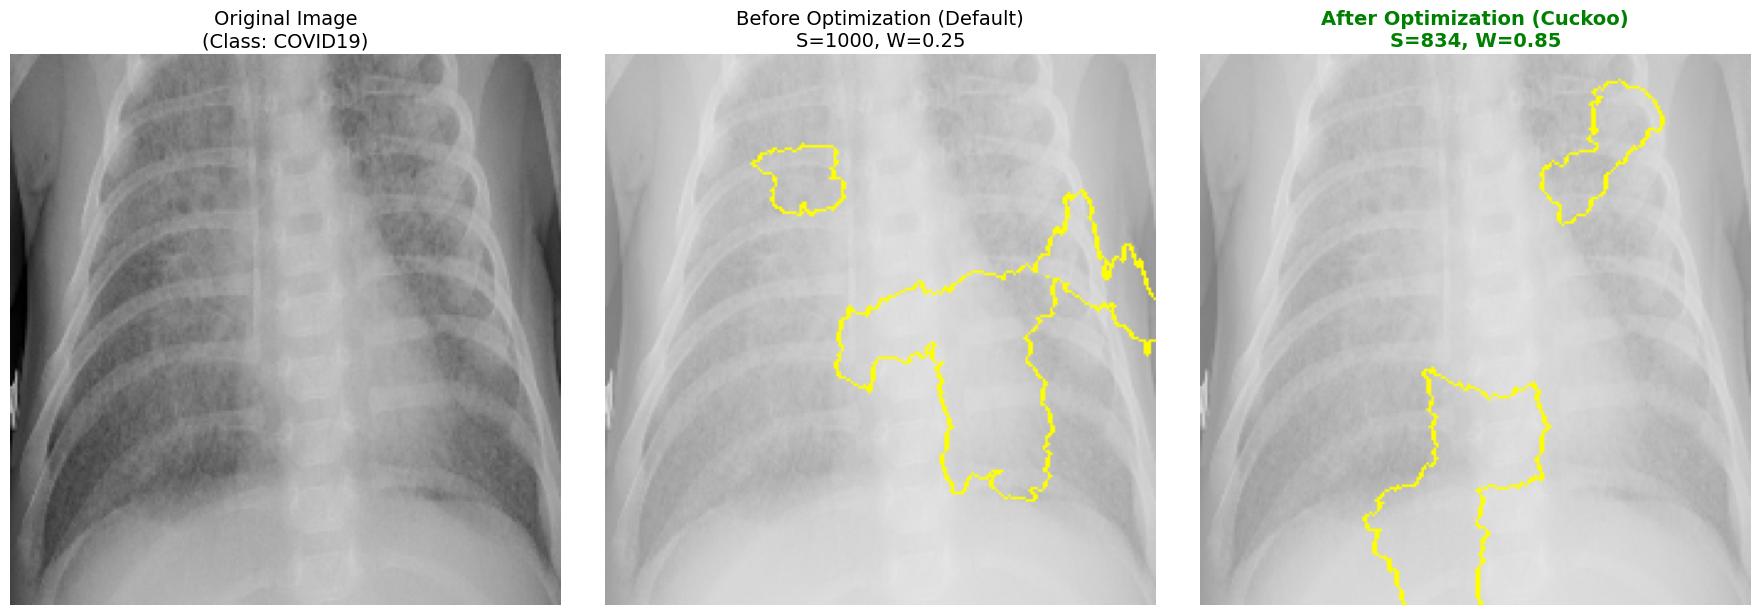

In [16]:
default_samples = 1000
default_width = 0.25

opt_samples = int(best_params[0])
opt_width = best_params[1]

print("Generating 'Before' (Default) Explanation...")
explainer_default = lime_image.LimeImageExplainer(kernel_width=default_width, verbose=False)
exp_default = explainer_default.explain_instance(
    target_img.astype('double'), predict_wrapper, top_labels=1, hide_color=0, 
    num_samples=default_samples, random_seed=42
)

print("Generating 'After' (Optimized) Explanation...")
explainer_opt = lime_image.LimeImageExplainer(kernel_width=opt_width, verbose=False)
exp_opt = explainer_opt.explain_instance(
    target_img.astype('double'), predict_wrapper, top_labels=1, hide_color=0, 
    num_samples=opt_samples, random_seed=42
)

pred_class = np.argmax(model.predict(target_img[np.newaxis, ...])[0])
temp_def, mask_def = exp_default.get_image_and_mask(
    pred_class, positive_only=True, num_features=5, hide_rest=False
)
temp_opt, mask_opt = exp_opt.get_image_and_mask(
    pred_class, positive_only=True, num_features=5, hide_rest=False
)


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(target_img)
ax[0].set_title(f"Original Image\n(Class: {categories[pred_class]})", fontsize=14)
ax[0].axis('off')

ax[1].imshow(mark_boundaries(temp_def / 2 + 0.5, mask_def))
ax[1].set_title(f"Before Optimization (Default)\nS={default_samples}, W={default_width}", fontsize=14)
ax[1].axis('off')

ax[2].imshow(mark_boundaries(temp_opt / 2 + 0.5, mask_opt))
ax[2].set_title(f"After Optimization (Cuckoo)\nS={opt_samples}, W={opt_width:.2f}", fontsize=14, color='green', fontweight='bold')
ax[2].axis('off')

plt.tight_layout()
plt.show()

In [17]:
import numpy as np

def optimize_lime_bat(model, image, label, n_bats=10, max_iter=5):
    print("Starting Bat Algorithm (BA) optimization...")

    f_min = 0.0
    f_max = 2.0
    

    A = 0.9      # Initial Loudness 
    r = 0.1      # Initial Pulse Rate 
    alpha = 0.9  # Cooling factor for Loudness
    gamma = 0.9  # Warming factor for Pulse Rate
    
    positions = np.random.uniform(LOWER_BOUND, UPPER_BOUND, (n_bats, 2))
    velocities = np.zeros((n_bats, 2))
    fitness = np.zeros(n_bats)
    
    for i in range(n_bats):
        fitness[i] = evaluate_lime_fidelity(positions[i], model, image, label)
    

    best_idx = np.argmax(fitness)
    best_pos = positions[best_idx].copy()
    best_score = fitness[best_idx]

    for t in range(max_iter):
        print(f"Iter {t+1}/{max_iter} | Best Score: {best_score:.4f} | Params: {best_pos}")
        
        for i in range(n_bats):
            beta = np.random.rand()
            freq = f_min + (f_max - f_min) * beta
            
            velocities[i] += (positions[i] - best_pos) * freq
            
            new_pos = positions[i] + velocities[i] 
            new_pos = np.clip(new_pos, LOWER_BOUND, UPPER_BOUND)

            if np.random.rand() > r:
                epsilon = np.random.uniform(-1, 1)
                new_pos = best_pos + epsilon * A
                new_pos = np.clip(new_pos, LOWER_BOUND, UPPER_BOUND)
            
            new_score = evaluate_lime_fidelity(new_pos, model, image, label)
            

            if (new_score > fitness[i]) and (np.random.rand() < A):
                positions[i] = new_pos
                fitness[i] = new_score
                
                A *= alpha      
                r *= (1 - np.exp(-gamma * t)) 
                
            if new_score > best_score:
                best_score = new_score
                best_pos = new_pos.copy()
                
    return best_pos, best_score


bat_params, bat_score = optimize_lime_bat(model, target_img, target_label)

print("\nBAT OPTIMIZATION FINISHED")
print(f"Optimal Samples: {int(bat_params[0])}")
print(f"Optimal Kernel Width: {bat_params[1]:.4f}")

Starting Bat Algorithm (BA) optimization...


  0%|          | 0/1823 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0069 | Mask Cover: 10.47%


  0%|          | 0/317 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 7.28%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.81%


  0%|          | 0/873 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 14.58%


  0%|          | 0/279 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0001 | Mask Cover: 8.50%


  0%|          | 0/1660 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.30%


  0%|          | 0/1662 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.1990 | Mask Cover: 10.58%


  0%|          | 0/1691 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.20%


  0%|          | 0/1027 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 18.79%


  0%|          | 0/768 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9164 | Mask Cover: 13.01%
Iter 1/5 | Best Score: 0.9973 | Params: [1.61832934e+03 9.95636683e-01]


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 12.32%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.61%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0009 | Mask Cover: 9.84%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9921 | Mask Cover: 10.05%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0001 | Mask Cover: 15.10%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9872 | Mask Cover: 14.69%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.01%


  0%|          | 0/1617 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0798 | Mask Cover: 7.66%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.81%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.78%
Iter 2/5 | Best Score: 0.9973 | Params: [1.61832934e+03 9.95636683e-01]


  0%|          | 0/1617 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0017 | Mask Cover: 12.89%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9617 | Mask Cover: 9.86%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.84%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.56%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.82%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.45%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.1233 | Mask Cover: 9.92%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0003 | Mask Cover: 11.39%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.57%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.55%
Iter 3/5 | Best Score: 0.9973 | Params: [1.61832934e+03 9.95636683e-01]


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 17.88%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.8448 | Mask Cover: 11.01%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 14.61%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 12.11%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.2547 | Mask Cover: 12.12%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 12.37%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 14.24%


  0%|          | 0/1617 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.6286 | Mask Cover: 16.64%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.77%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.71%
Iter 4/5 | Best Score: 0.9973 | Params: [1.61832934e+03 9.95636683e-01]


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.48%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 10.30%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.98%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0331 | Mask Cover: 11.66%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 12.28%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0303 | Mask Cover: 14.76%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 13.98%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 8.93%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.40%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 17.93%
Iter 5/5 | Best Score: 0.9973 | Params: [1.61832934e+03 9.95636683e-01]


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 15.70%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 9.78%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9699 | Mask Cover: 13.72%


  0%|          | 0/1617 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.4813 | Mask Cover: 23.30%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.9018 | Mask Cover: 16.78%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0064 | Mask Cover: 11.38%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 11.16%


  0%|          | 0/1617 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 15.34%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0000 | Mask Cover: 15.71%


  0%|          | 0/1618 [00:00<?, ?it/s]

  [Debug] Orig: 0.9973 | Pert: 0.0779 | Mask Cover: 9.84%

BAT OPTIMIZATION FINISHED
Optimal Samples: 1618
Optimal Kernel Width: 0.9956


Generating Default Explanation...


  0%|          | 0/1000 [00:00<?, ?it/s]

Generating Bat Optimized Explanation...


  0%|          | 0/1618 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


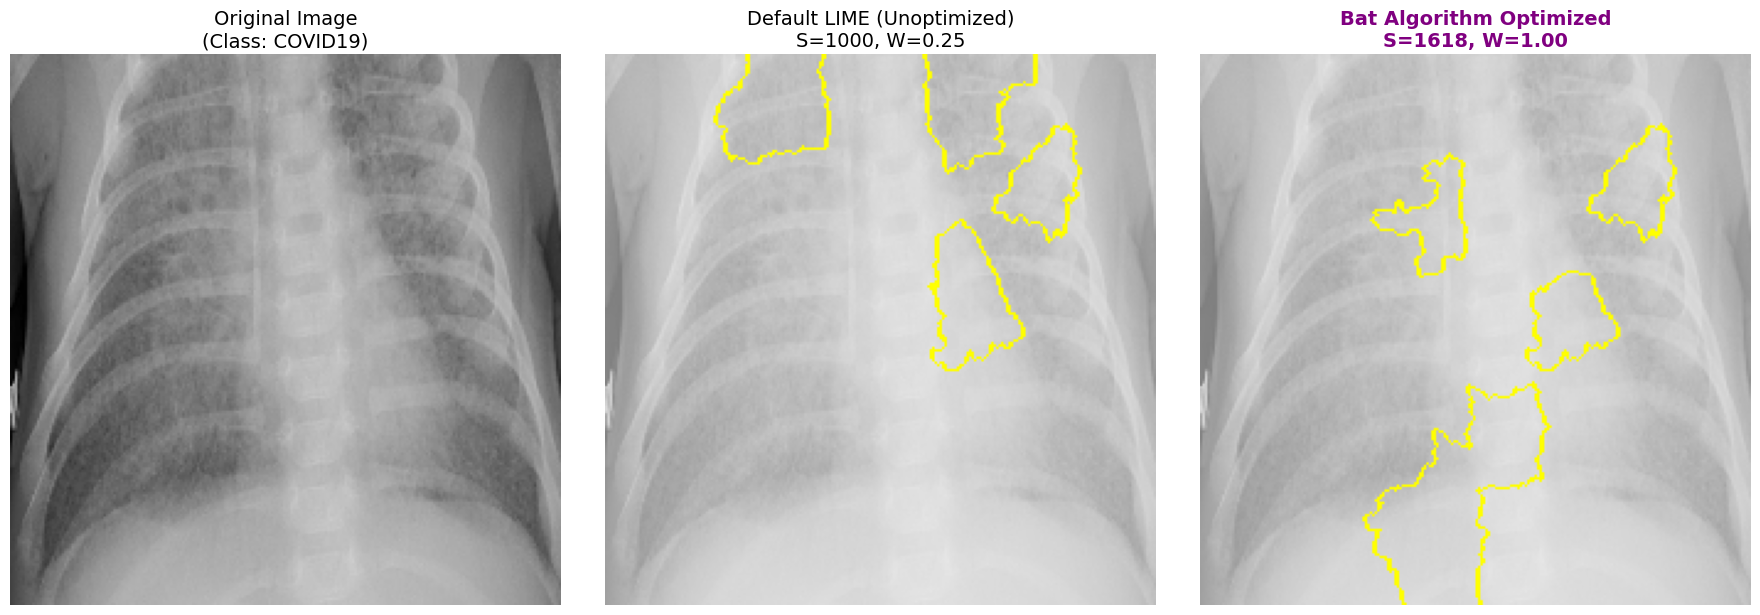

In [19]:
opt_samples_bat = int(bat_params[0])
opt_width_bat = bat_params[1]

print("Generating Default Explanation...")
explainer_default = lime_image.LimeImageExplainer(kernel_width=default_width, verbose=False)
exp_default = explainer_default.explain_instance(
    target_img.astype('double'), predict_wrapper, top_labels=1, hide_color=0, 
    num_samples=default_samples, random_seed=42
)


print("Generating Bat Optimized Explanation...")
explainer_bat = lime_image.LimeImageExplainer(kernel_width=opt_width_bat, verbose=False)
exp_bat = explainer_bat.explain_instance(
    target_img.astype('double'), predict_wrapper, top_labels=1, hide_color=0, 
    num_samples=opt_samples_bat, random_seed=42
)

pred_class = np.argmax(model.predict(target_img[np.newaxis, ...])[0])

temp_def, mask_def = exp_default.get_image_and_mask(
    pred_class, positive_only=True, num_features=5, hide_rest=False
)

temp_bat, mask_bat = exp_bat.get_image_and_mask(
    pred_class, positive_only=True, num_features=5, hide_rest=False
)


fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot 1: Original
ax[0].imshow(target_img)
label_name = categories[pred_class] if 'categories' in globals() else str(pred_class)
ax[0].set_title(f"Original Image\n(Class: {label_name})", fontsize=14)
ax[0].axis('off')

# Plot 2: Default LIME
ax[1].imshow(mark_boundaries(temp_def / 2 + 0.5, mask_def))
ax[1].set_title(f"Default LIME (Unoptimized)\nS={default_samples}, W={default_width}", fontsize=14)
ax[1].axis('off')

# Plot 3: Bat Optimized LIME
ax[2].imshow(mark_boundaries(temp_bat / 2 + 0.5, mask_bat))
ax[2].set_title(f"Bat Algorithm Optimized\nS={opt_samples_bat}, W={opt_width_bat:.2f}", fontsize=14, color='purple', fontweight='bold')
ax[2].axis('off')

plt.tight_layout()
plt.show()